This notebook is used to test various ways to determine the tail exponent for the distribution of aggregate losses. Clearly, only when the severities are heavy tail distributed the sum is heavy tail distributed, otherwise the tail is always lighter than polynomial (shown here the the standard example of lognormal severities).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
from functions.loss import full_aggregate_pareto_losses, full_aggregate_lognorm_losses
import functions.analysis as fa

In [ ]:
# Generate simulated aggregate loss data (Monte Carlo)
simul_pareto=full_aggregate_pareto_losses(1, 100, 1000000) # the first variable is the tail index
simul_lognorm=full_aggregate_lognorm_losses(1, 100, 1000000) # the first variable is the shape parameter
# by default, the scale parameters for both are set to 1.
# both have Poisson distributed frequencies with mean 100 in this example

Text(0.5, 0, 'Threshold u')

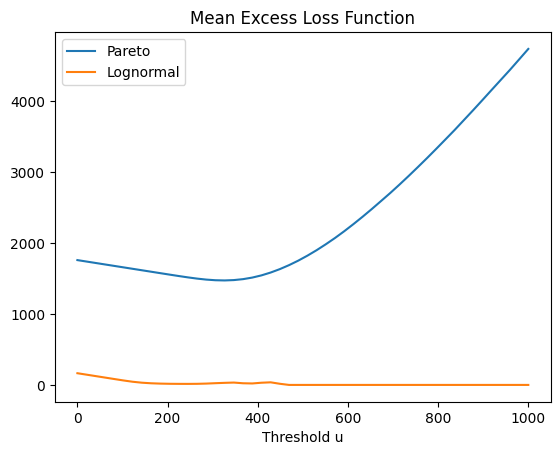

In [4]:
# plot of mean excess loss function
u_values = np.linspace(0, 1000, 50)
mel_values_p = [fa.mean_excess_loss(simul_pareto, u) for u in u_values]
mel_values_l = [fa.mean_excess_loss(simul_lognorm, u) for u in u_values]
plt.plot(u_values, mel_values_p, label='Pareto')
plt.plot(u_values, mel_values_l, label='Lognormal')
plt.title('Mean Excess Loss Function')
plt.legend()
plt.xlabel('Threshold u')

As expected, sums of heavy-tailed distributed variables are heavy tail distributed, so the Pareto has a heavy tail. The tail exponent tends to the same value of course (think of alpha-stable distributions, where the tail exponent remains strictly the same when doing convolutions!)

Text(0.5, 0, 'k (number of top order statistics)')

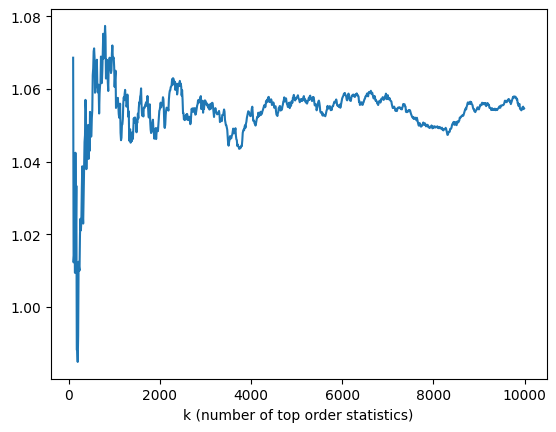

In [ ]:
# plot of hill estimator as function of k
k_values = np.arange(100, 10000,10)
hill_values = np.array([fa.hill_estimator(simul_pareto, k) for k in k_values])
plt.plot(k_values, hill_values)
#plt.xlabel('k (number of top order statistics)')
#plt.ylim(0.5, 1.5)

1/hill estimator is an estimator of the tail index. Specifically, one must identify the range of stability.

Text(0.5, 1.0, 'Histogram of Aggregate Losses')

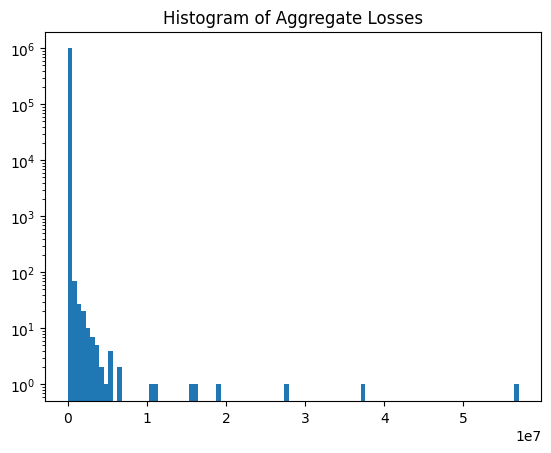

In [6]:
# histogram of aggregate losses for pareto severities
plt.figure()
plt.hist(simul_pareto, bins=100, label='Pareto')
plt.yscale('log')
#plt.xscale('log')
plt.title('Histogram of Aggregate Losses')

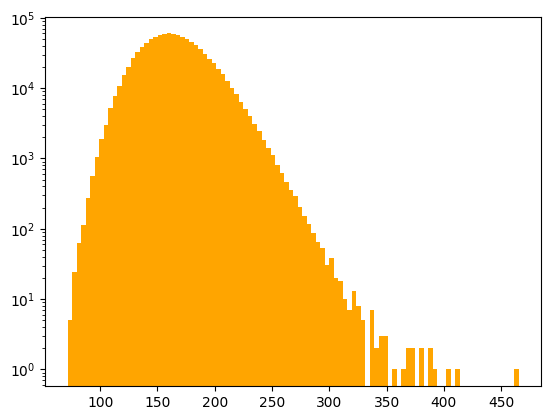

In [7]:
# histogram of aggregate losses for lognormal severities
plt.figure()
plt.hist(simul_lognorm, bins=100, label='Lognormal', color='orange')
plt.yscale('log')
plt.show()

Initial alpha (from Hill, k=30000): 0.9007
Fitted alpha (histogram log-log): 1.0865


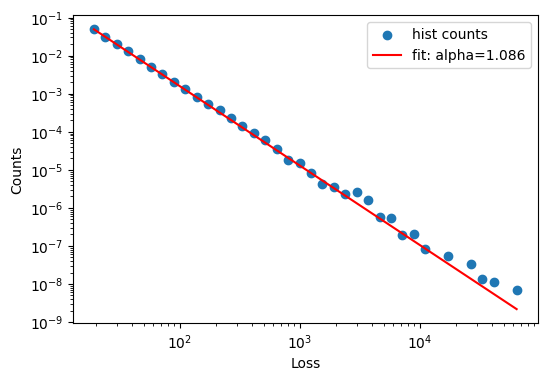

In [ ]:
# Fit tail exponent for pareto sum by fitting histogram on log-log scale

rescaled_simul = simul_pareto/np.median(simul_pareto)

# choose k for hill estimator initial guess
n = len(rescaled_simul)
k0 = max(10, int(0.03 * n))
gamma_hat = fa.hill_estimator(rescaled_simul, k0)  # hill gives gamma = 1/alpha
alpha0 = 1.0 / gamma_hat # initial alpha estimate
print(f'Initial alpha (from Hill, k={k0}): {alpha0:.4f}')

# select tail threshold and compute log-spaced histogram
u_min = np.percentile(rescaled_simul, 99)
u_max = np.percentile(rescaled_simul, 100)
tail = rescaled_simul[(rescaled_simul > u_min) & (rescaled_simul < u_max)]

bins = np.logspace(np.log10(u_min), np.log10(u_max), 40)
counts, edges = np.histogram(tail, bins=bins, density=True) # density=True for PDF, otherwise the fit is off (because the bins are not uniform in width)
bin_centers = np.sqrt(edges[:-1] * edges[1:])

# use only bins with positive counts in the tail region
mask = counts > 0
x = bin_centers[mask]
y = counts[mask].astype(float)

def power_law(x, A, alpha):
    return A * x ** (-alpha-1)

p0 = [y.max(), alpha0]

popt, pcov = curve_fit(power_law, x, y, p0=p0, maxfev=10000)
A_fit, alpha_fit = popt
print(f'Fitted alpha (histogram log-log): {alpha_fit:.4f}')


# plot results
plt.figure(figsize=(6,4))
plt.scatter(x, y, label='hist counts')
xx = np.linspace(x.min(), x.max(), 200)
plt.plot(xx, power_law(xx, A_fit, alpha_fit),
         color='red', label=f'fit: alpha={alpha_fit:.3f}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Loss')
plt.ylabel('Counts')
plt.legend()
plt.show()


In [ ]:
# calculation of tail exponent from pareto tail index MLE (maximum likelihood estimator) 
fa.pareto_tail_mle(rescaled_simul,p_min=0.95)

np.float64(1.1622902465725196)

In [ ]:
# fit of tail exponent from tail of survival function
fa.pareto_tail_survival(rescaled_simul,p_min=0.95)

np.float64(1.0944086286137702)

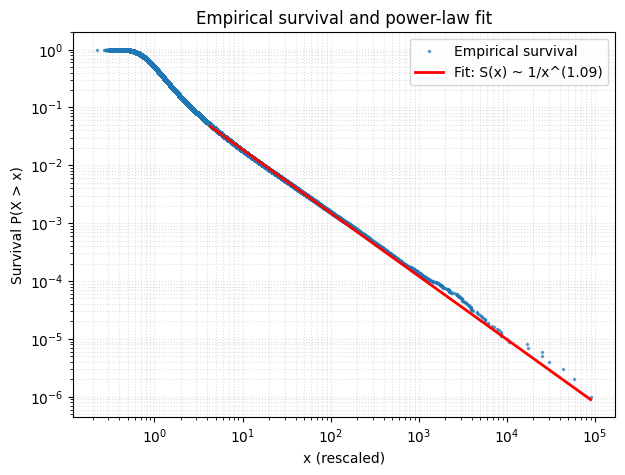

In [16]:
# plot of survival function and power-law fit on loglog plot
x = np.sort(np.asarray(rescaled_simul)) # sorting the data allows to easily compute empirical survival below!
n = len(x)

# empirical survival S(x) = P(X > x) evaluated at sorted x
surv = 1.0 - np.arange(0, n) / n  # survival at x[i] is 1 - i/n

# choose tail threshold
p_tail = 0.95
u = np.quantile(x, p_tail)
mask = x >= u

# fit log-log line: log S = intercept + slope * log x
logx = np.log(x[mask])
logsurv = np.log(surv[mask])
slope, intercept = np.polyfit(logx, logsurv, 1)
alpha_hat = -slope

# plot on log-log
plt.figure(figsize=(7,5))
plt.loglog(x, surv, marker='.', linestyle='none', markersize=3, alpha=0.6, label='Empirical survival')
# overlay fitted straight line (extrapolate across the tail region)
x_fit = np.linspace(x[mask].min(), x[mask].max(), 200)
plt.loglog(x_fit, np.exp(intercept) * x_fit**slope, 'r-', lw=2, label=f'Fit: S(x) ~ 1/x^({alpha_hat:.2f})')

plt.xlabel('x (rescaled)')
plt.ylabel('Survival P(X > x)')
plt.title(f'Empirical survival and power-law fit')
plt.legend()
plt.grid(which='both', linestyle=':', alpha=0.4)
plt.show()

Using fitted alpha=1.0865, A=23.47


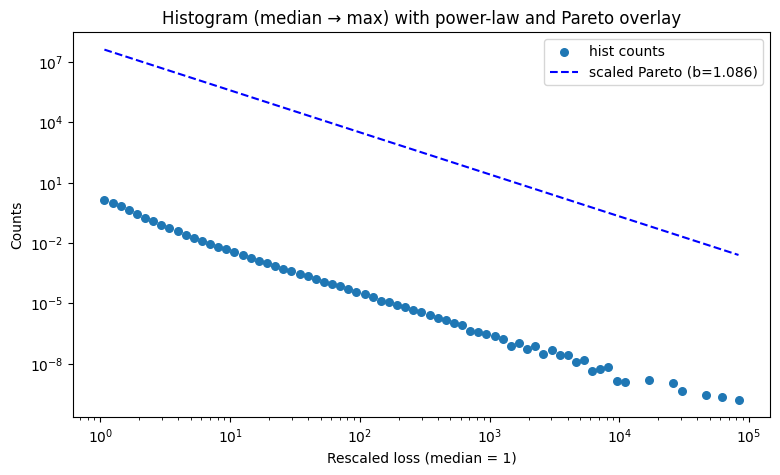

In [ ]:
from scipy.stats import pareto, lognorm

# Plot histogram from median to max and use fitted results from the previous cell

res = rescaled_simul
A_fit_used = A_fit
alpha_fit_used = alpha_fit
print(f"Using fitted alpha={alpha_fit_used:.4f}, A={A_fit_used:.4f}")

# Plot from the 50th percentile (median) to max of the data
u_min_plot = np.percentile(res, 50)
u_max_plot = res.max()

bins = np.logspace(np.log10(u_min_plot), np.log10(u_max_plot), 80)
counts, edges = np.histogram(res, bins=bins,density=True)
bin_centers = np.sqrt(edges[:-1] * edges[1:]) # geometric mean for log-spaced bins!
mask = counts > 0
x = bin_centers[mask]
y = counts[mask].astype(float)

# plotting
xx = np.logspace(np.log10(x.min()), np.log10(x.max()), 500)
plt.figure(figsize=(9,5))
plt.scatter(x, y, s=30, label='hist counts')

# overlay a Pareto PDF scaled to counts for comparison
b_par = max(0.01, alpha_fit_used)
scale_par = u_min_plot
pdf_vals = pareto.pdf(xx, b_par, scale=scale_par)
bin_widths = edges[1:] - edges[:-1]
rep_dx = np.median(bin_widths)
expected_counts = pdf_vals * len(res) * rep_dx
plt.plot(xx, expected_counts, color='blue', lw=1.5, linestyle='--',
         label=f'scaled Pareto (b={b_par:.3f})')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rescaled loss (median = 1)')
plt.ylabel('Counts')
plt.legend()
plt.title('Histogram (median → max) with power-law and Pareto overlay')
plt.show()


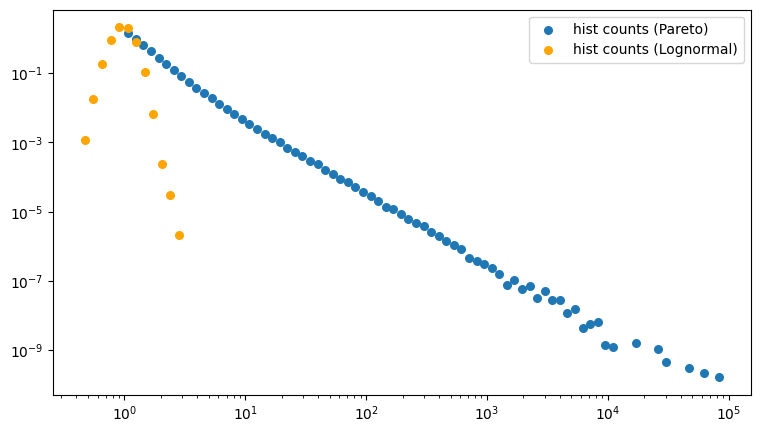

In [21]:
# comparison of lognormal and pareto histograms on log-log scale, as done previously

res_l= simul_lognorm/np.median(simul_lognorm)

# choose data limits
u_min_plot = min(res.min(), res_l.min())
u_max_plot = max(res.max(), res_l.max())

bins = np.logspace(np.log10(u_min_plot), np.log10(u_max_plot), 80)

counts, edges = np.histogram(res, bins=bins,density=True)
bin_centers = np.sqrt(edges[:-1] * edges[1:]) # geometric mean for log-spaced bins!

counts_l, edges_l = np.histogram(res_l, bins=bins,density=True)
bin_centers_l = np.sqrt(edges_l[:-1] * edges_l[1:]) # geometric mean for log-spaced bins!

mask_l = counts_l > 0
x_l = bin_centers_l[mask_l]
y_l = counts_l[mask_l].astype(float)

# plotting
plt.figure(figsize=(9,5))
plt.scatter(x, y, s=30, label='hist counts (Pareto)') 
plt.scatter(x_l, y_l, s=30, label='hist counts (Lognormal)', color='orange')

plt.xscale('log')
plt.yscale('log')

plt.legend()


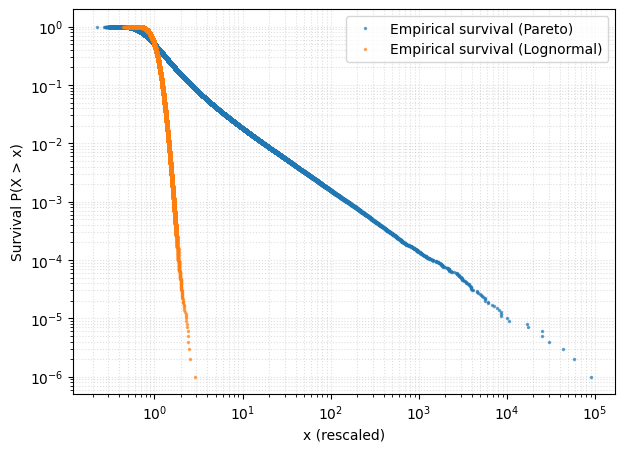

In [22]:
# plot of survival function and power-law fit on loglog plot
x = np.sort(np.asarray(res)) # sorting the data allows to easily compute empirical survival below!
n = len(x)

x_l = np.sort(np.asarray(res_l))
n_l = len(x_l)

# empirical survival S(x) = P(X > x) evaluated at sorted x
surv = 1.0 - np.arange(0, n) / n  # survival at x[i] is 1 - i/n
surv_l = 1.0 - np.arange(0, n_l) / n_l

# choose tail threshold
p_tail = 0.5
u = np.quantile(x, p_tail)
u_l = np.quantile(x_l, p_tail)
mask = x >= u
mask_l = x_l >= u_l


# plot on log-log
plt.figure(figsize=(7,5))
plt.loglog(x, surv, marker='.', linestyle='none', markersize=3, alpha=0.6, label='Empirical survival (Pareto)')
plt.loglog(x_l, surv_l, marker='.', linestyle='none', markersize=3, alpha=0.6, label='Empirical survival (Lognormal)')
plt.xlabel('x (rescaled)')
plt.ylabel('Survival P(X > x)')
plt.legend()
plt.grid(which='both', linestyle=':', alpha=0.4)
plt.show()